# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/jelosua/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/jelosua/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/jelosua/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/jelosua/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/jelosua/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/jelosua/.virtualenvs

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [2]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [4]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [44]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [45]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets.text.fillna(tweets.full_text, inplace=True)

Add many time grouping columns.

In [46]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

# Sources

In [47]:
tweets['source_clean'] = tweets['source'].apply(stripHTML)
tweets['source_clean'].unique()

array([b'Twitter for iPhone', b'Media Studio', b'Twitter Web Client',
       b'Twitter Ads', b'Twitter for Android'], dtype=object)

# Frequencies

## Total Tweets

In [48]:
len(tweets.index)

1296

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

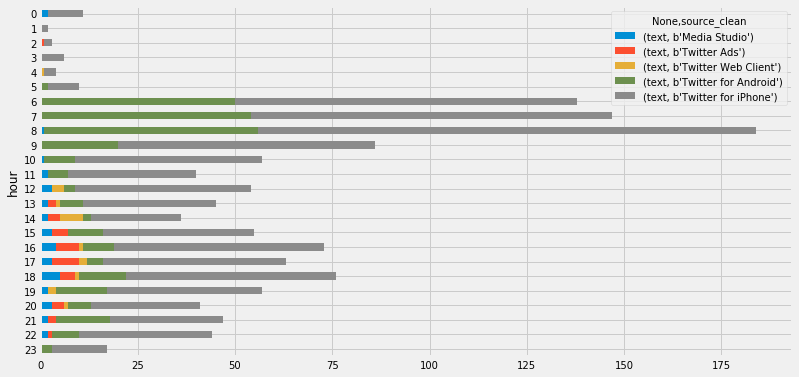

In [49]:
tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
    index='hour', columns=['source_clean'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

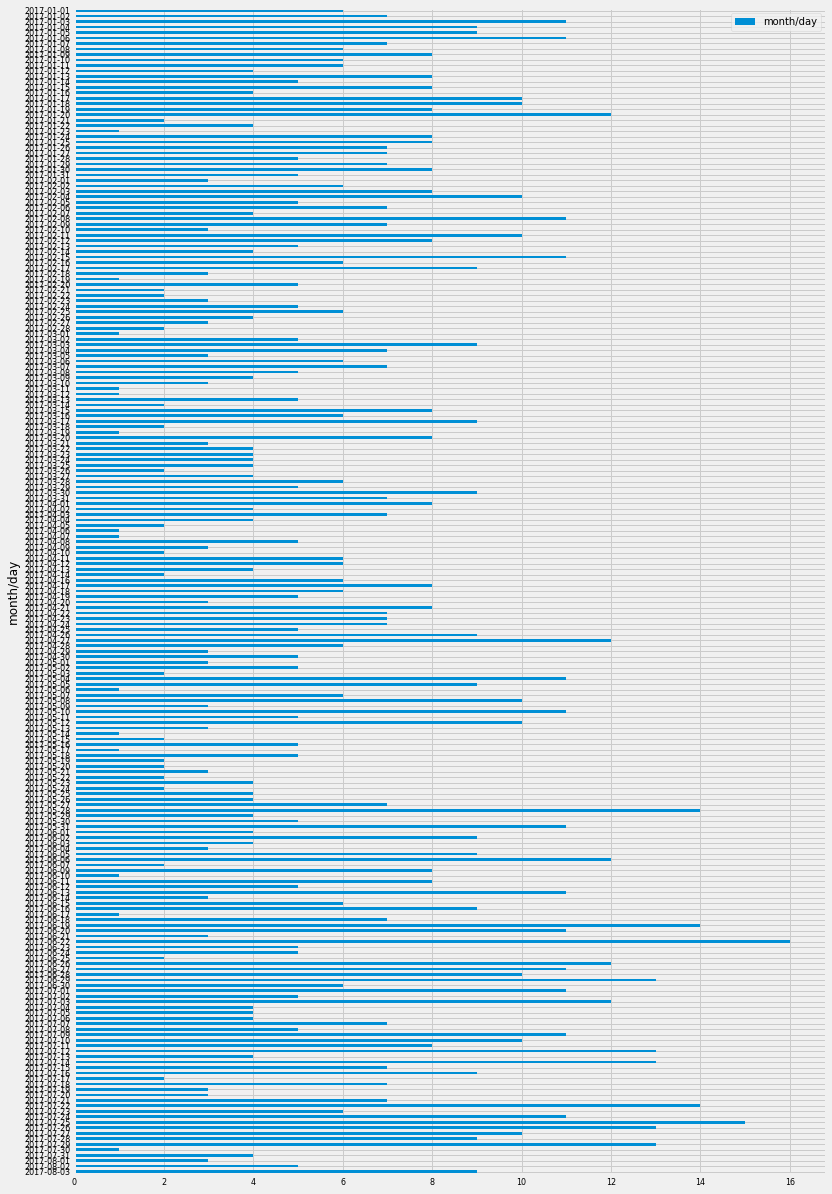

In [50]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,20), fontsize=8)

In [51]:
tweetsPerDay.describe()

,month/day
count,213.000000
mean,6.084507
std,3.401220
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,16.000000


## Tweets per day of week

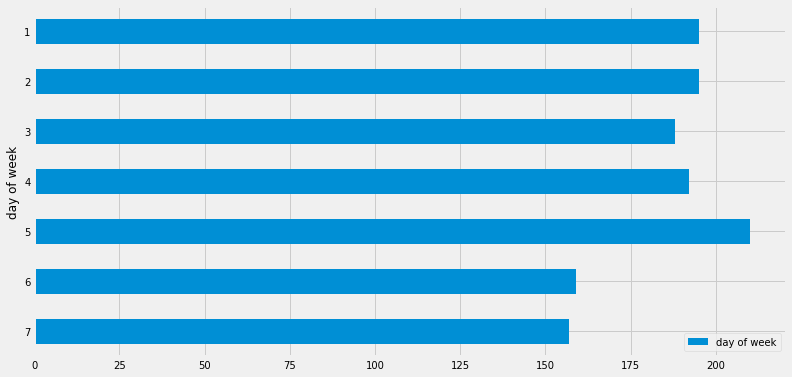

In [52]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

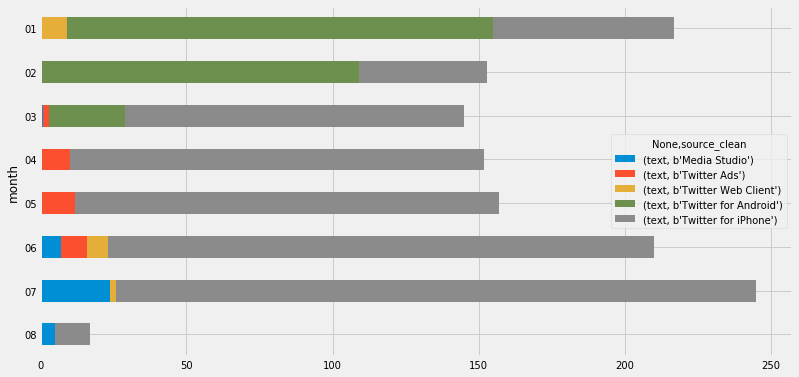

In [53]:
tweetsPerMonth = tweets[['source_clean', 'month', 'text']].pivot_table(index='month', columns=['source_clean'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

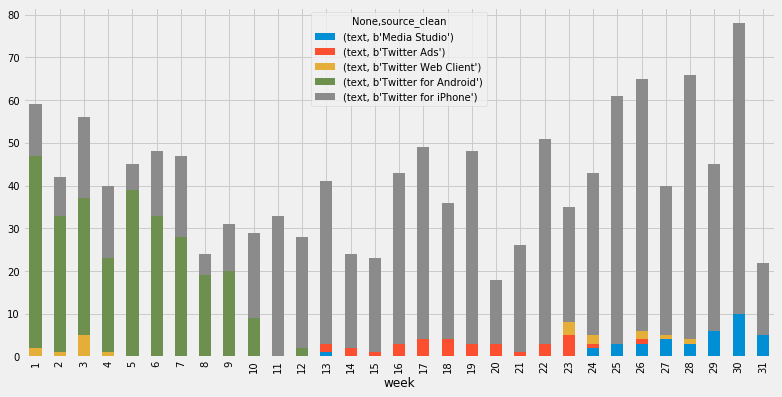

In [54]:
tweetsPerWeek = tweets[['source_clean', 'week', 'text']].pivot_table(index='week', columns=['source_clean'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [55]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [56]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [57]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2017-06-13 10:35:55,-0.9544,The Fake News Media has never been so wrong or...
2017-02-07 12:11:29,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-02-07 12:04:01,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-01-15 22:46:33,-0.9354,.@NBCNews is bad but Saturday Night Live is th...


In [58]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-01-01 06:49:49,0.9765,RT @IvankaTrump: 2016 has been one of the most...
2017-07-27 22:49:05,0.9735,It was my great HONOR to present our nation's ...
2017-01-22 12:35:09,0.9679,Had a great meeting at CIA Headquarters yester...
2017-02-02 11:25:40,0.9674,Attending Chief Ryan Owens' Dignified Transfer...
2017-02-01 03:45:26,0.9666,Hope you like my nomination of Judge Neil Gors...


In [59]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-08-02 14:09:37,31,0.9473,It was my great honor to pay tribute to a VET ...
2017-08-03 12:05:07,31,0.8599,RT @JacobAWohl: @realDonaldTrump The #MAGA gre...
2017-08-03 18:03:33,31,0.8283,"Today, I announced another historic breakthro..."
2017-08-03 12:12:21,31,0.7745,I am continuing to get rid of costly and unnec...
2017-08-03 22:52:16,31,0.7290,Just arrived in West Virginia for a MAKE AMERI...
2017-08-03 12:08:54,31,0.7263,Business is looking better than ever with busi...
2017-08-03 19:07:40,31,0.7034,Our GREAT VETERANS can now connect w/ their VA...
2017-07-31 22:19:11,31,0.6588,A great day at the White House!
2017-08-03 01:29:46,31,0.5709,"I love the White House, one of the most beauti..."


## By month

### Average

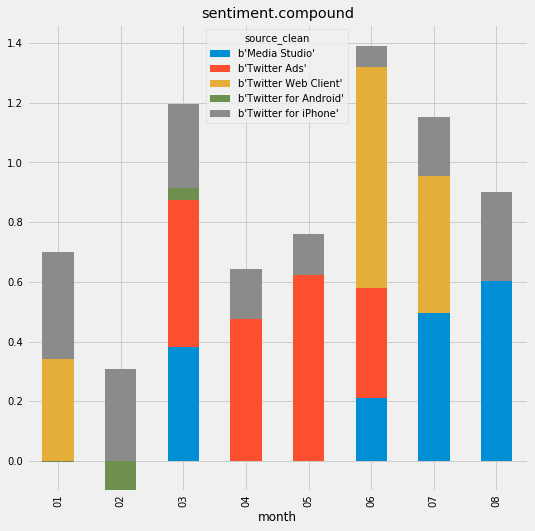

In [60]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

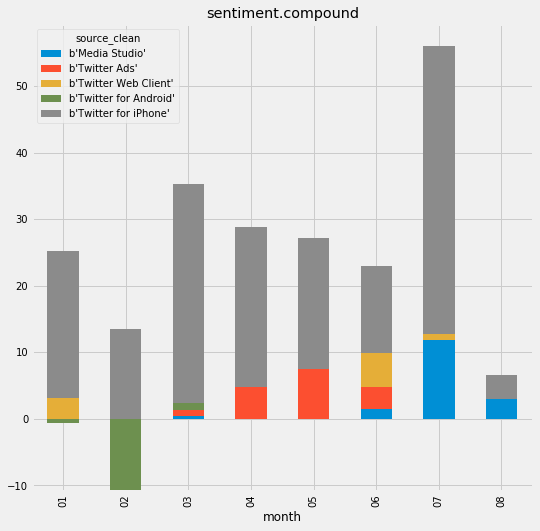

In [61]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

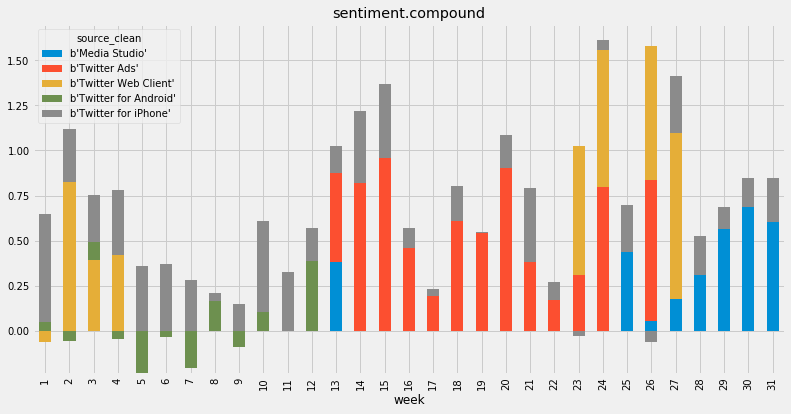

In [62]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

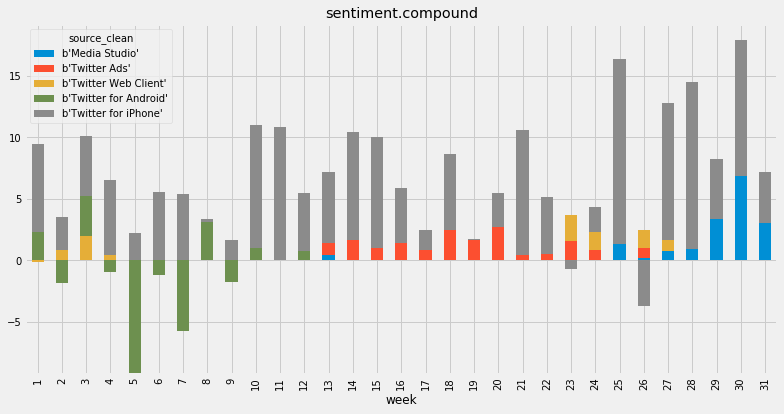

In [63]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

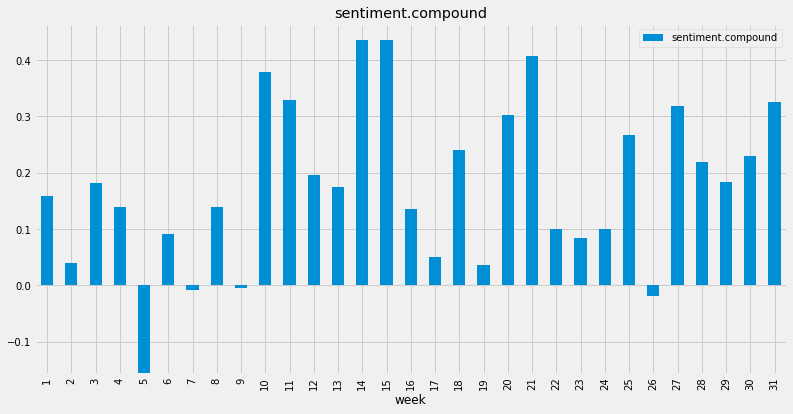

In [64]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

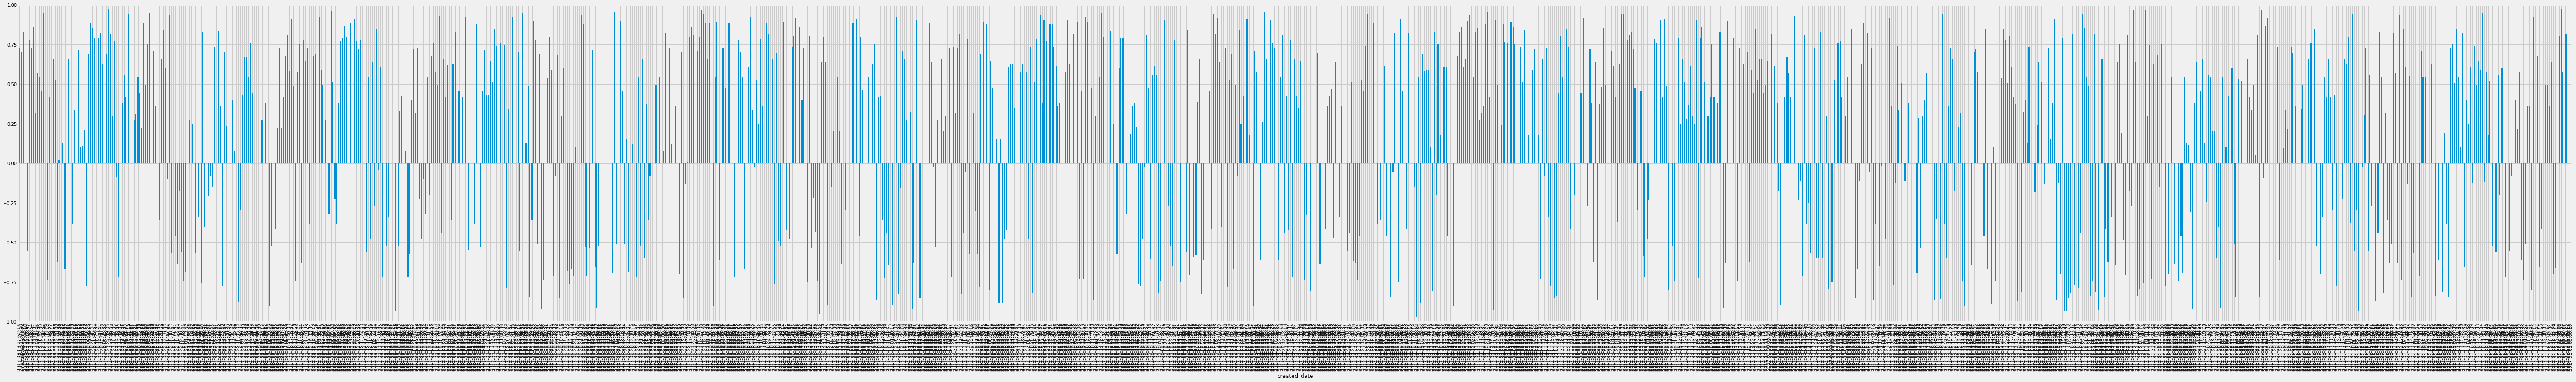

In [65]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

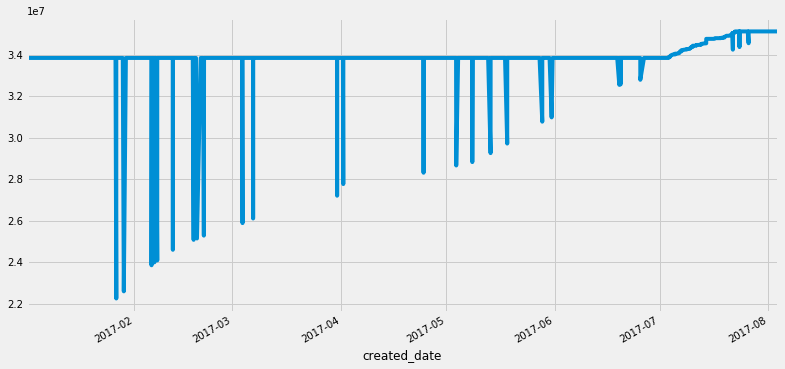

In [66]:
tweets['user.followers_count'].plot()

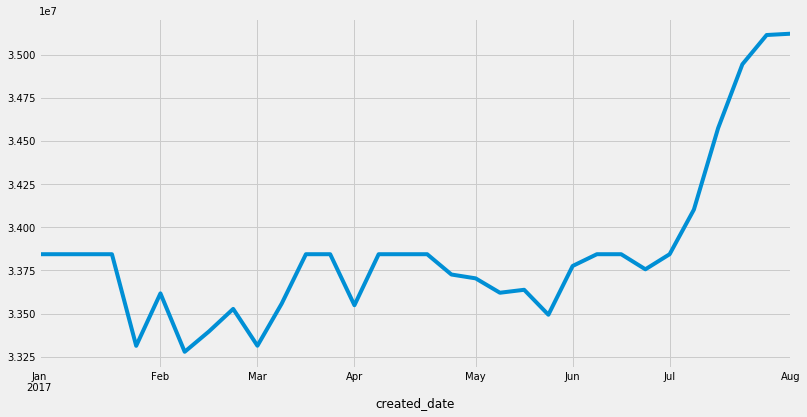

In [67]:
tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [68]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-08-02 14:09:37,31,0.9473,It was my great honor to pay tribute to a VET ...,892749228291874816
2017-08-03 12:05:07,31,0.8599,RT @JacobAWohl: @realDonaldTrump The #MAGA gre...,893080287755849729
2017-08-03 18:03:33,31,0.8283,"Today, I announced another historic breakthro...",893170489820151808
2017-08-03 12:12:21,31,0.7745,I am continuing to get rid of costly and unnec...,893082107081244672
2017-08-03 22:52:16,31,0.7290,Just arrived in West Virginia for a MAKE AMERI...,893243147580473344
2017-08-03 12:08:54,31,0.7263,Business is looking better than ever with busi...,893081237082001409
2017-08-03 19:07:40,31,0.7034,Our GREAT VETERANS can now connect w/ their VA...,893186623193718784
2017-07-31 22:19:11,31,0.6588,A great day at the White House!,892147656319004672
2017-08-03 01:29:46,31,0.5709,"I love the White House, one of the most beauti...",892920397162848257


In [69]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')

# Text analysis

Common words.

In [70]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jelosua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,&amp;,209,b'&amp;'
1,great,201,b'great'
2,',129,"b""'"""
3,-,102,b'-'
4,!,102,b'!'
5,fake,95,b'fake'
6,.,85,b'.'
7,big,79,b'big'
8,u..,76,b'u..'
9,news,75,b'news'


# Specific text searches

In [77]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source_clean', 'week', 'text']].pivot_table(index='week', columns='source_clean', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweetsEnc['week'].min(), tweetsEnc['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source_clean', 'hour', 'text']].pivot_table(index='hour', columns='source_clean', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [ ]:
tweetsEnc

In [76]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)

## Search: _great_

AttributeError: 'Series' object has no attribute 'decode'